<div id="section1"   dir='rtl'>
<h1>
    تمیز کردن و مصورسازی دادگان
    </h1>
        <hr>
        در این قسمت با تمیز کردن و مصورسازی دادگان، به تحلیل و بررسی آن‌ها می‌پردازیم:

</div>

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_ad = pd.read_csv('ad.csv')
df_adtitle = pd.read_csv('ad_title.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000252F2171108>,
      dtype=object)

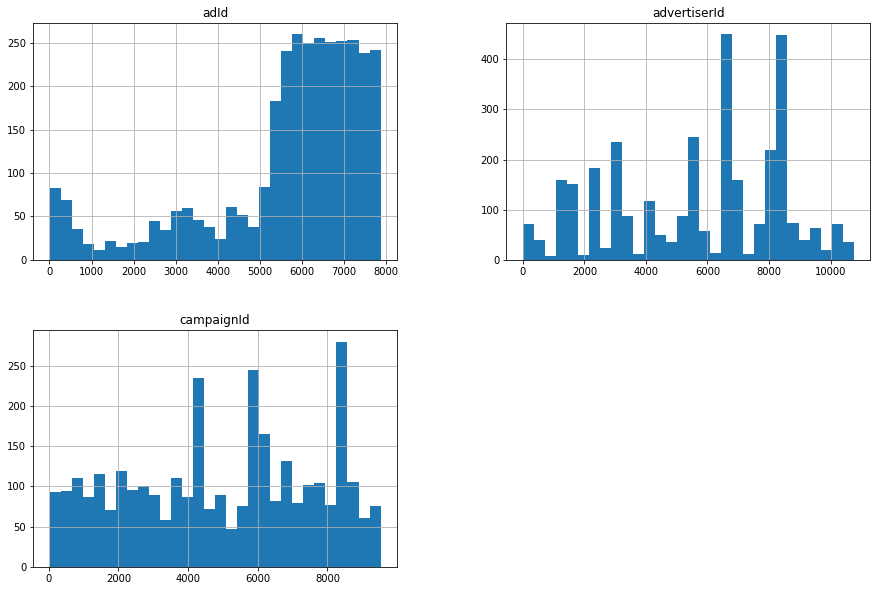

In [4]:
df_ad.hist(bins=30, figsize=(15, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000252F2A49288>,
      dtype=object)

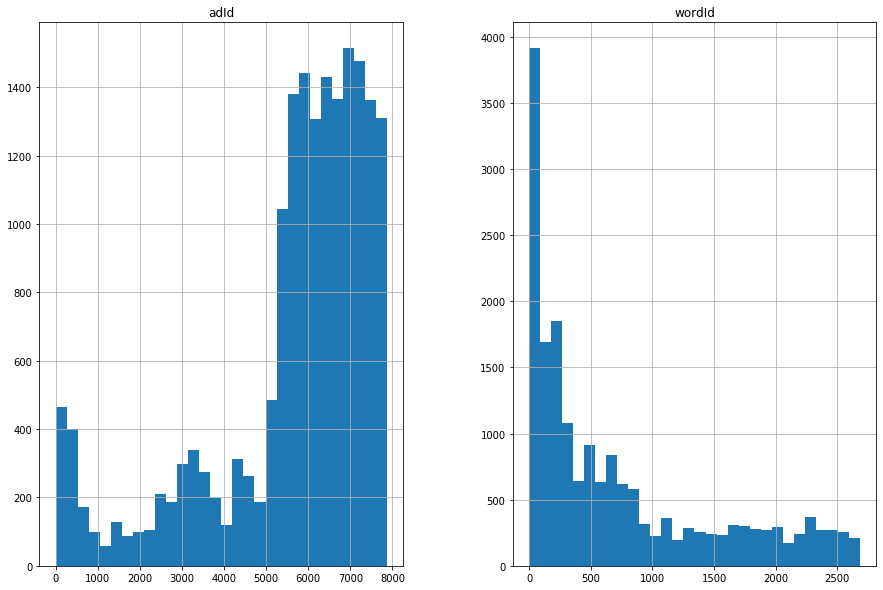

In [5]:
df_adtitle.hist(bins=30, figsize=(15, 10))

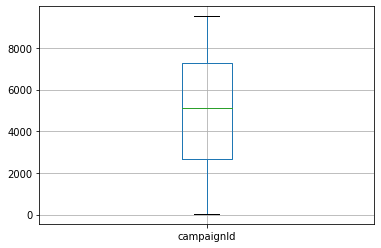

In [6]:
df_ad.boxplot(['campaignId'])

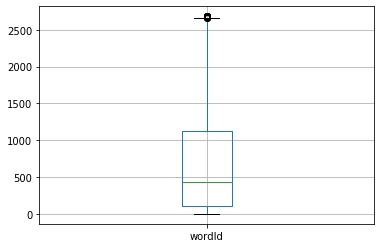

In [7]:
df_adtitle.boxplot(['wordId'])

In [8]:
#پیدا کردن تعداد تبلیغ های متعلق به هر کمپین
df_adg = df_ad.groupby(['campaignId']).agg({'adId':'count'}).reset_index()
df_adg['adId'].max()

211

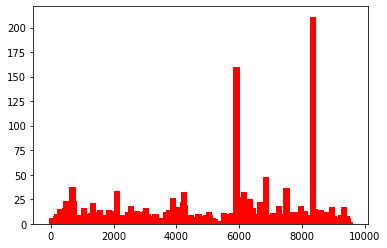

In [9]:
#نمودار تعداد تبلیغ های متعلق به هر کمپین، محور افقی کمپین
plt.bar(df_adg['campaignId'], df_adg['adId'], width=200, color='red')  
plt.show()

In [10]:
#پیدا کردن تعداد تبلیغ های متعلق به هر تبلیغ کننده
df_adg = df_ad.groupby(['advertiserId']).agg({'adId':'count'}).reset_index()
df_adg['adId'].max()

424

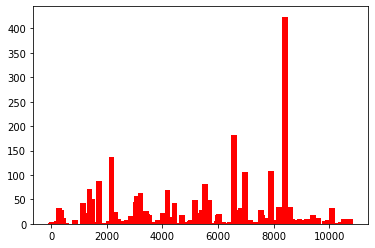

In [11]:
#نمودار تعداد تبلیغ های متعلق به هر تبلیغ کننده، محور افقی تبلیغ کننده
plt.bar(df_adg['advertiserId'], df_adg['adId'], width=200, color='red')
plt.show()
del(df_adg)

In [12]:
#پیدا کردن تعداد تبلیغ های متعلق به هر کلمه
df_adtitleg = df_adtitle.groupby(['wordId']).agg({'adId':'count'}).reset_index()
df_adtitleg['adId'].max()

567

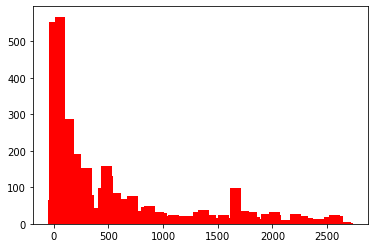

In [13]:
#نمودار تعداد تبلیغ های متعلق به هر کلمه، محور افقی کلمات
plt.bar(df_adtitleg['wordId'], df_adtitleg['adId'], width=100, color='red')
plt.show()
del(df_adtitleg)

In [14]:
#پیدا کردن تعداد کمپین هایی که هر تبلیغ عضو هست
df_adidg = df_ad.groupby(['adId']).agg({'campaignId':'count'}).reset_index()
df_adidg['campaignId'].max()
del(df_adidg)

In [15]:
#پیدا کردن تعداد کلماتی هایی که هر تبلیغ داره
df_adtg = df_adtitle.groupby(['adId']).agg({'wordId':'count'}).reset_index()
df_adtg['wordId'].max()

11

In [16]:
df_adtg['wordId'].min()

1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000252F48CF908>,
      dtype=object)

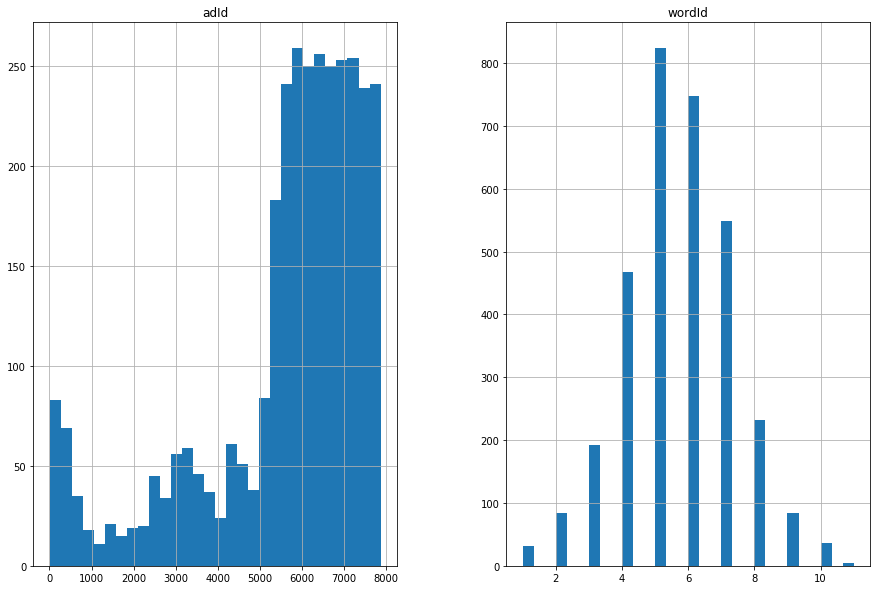

In [17]:
df_adtg.hist(bins=30, figsize=(15, 10))

<div id="section1"   dir='rtl'>
<h1>
    عنوان؟؟؟؟
    </h1>
        <hr>
        
       توضیحات؟؟؟؟

</div>

In [ ]:
import pandas as pd
import numpy as np

df_uf = pd.read_csv('user_feature.cvs')

df_new_uf = df_uf.drop(columns = ['Unnamed: 0','VC','visit_number'])
del(df_uf)

arr = pd.DataFrame(df_new_uf['topicId'].drop_duplicates()).reset_index()
#arr.info()

arr['index'] = arr['topicId']
arr['topicId'] = arr['topicId'].astype('object')
#arr.info()

df_inx = pd.get_dummies(arr)
del(arr)

df_inx.rename(columns = {'index':'topicId'}, inplace = True)

df_new_uf['like_point'] = df_new_uf['like_point'] * 100
df_new_uf['like_point'] = df_new_uf['like_point'].astype('unit8')

df_uf = pd.merge(df_new_uf, df_inx, how = 'inner', on = 'topicId')
df_uf.head()

del(df_new_uf)

for i in range(3,53):
    df_uf.iloc[:,i] = df_uf.iloc[:,i] * df_uf['like_point']
df_uf.info()

df_user_feature = df_uf.groupby(['userId'])[df_uf.filter(regex='topicId_.*').columns].sum()
#df_user_feature.info()
#df_user_feature.head(20)

df_user_feature.to_csv('user_like.csv')

<div id="section1"   dir='rtl'>
<h1>
    خوشه بندی کاربرها
    </h1>
        <hr>
        در این مرحله با استفاده از جدول
    user_like.csv
    که در مراحل قبل به دست آوردیم، کاربرها را خوشه‌بندی می‌کنیم و نهایتا خروجی کد را در فایل
    user_cluster می‌ریزیم.
        <br>
        کد زیر این کار را انجام میدهد:

</div>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

df_user_feature = pd.read_csv('user_like.csv')

X = df_user_feature.iloc[:, 1:53].values
kmeans = KMeans(n_clusters=28, init='k-means++', max_iter=500, n_init=10)
pred_y = kmeans.fit_predict(X)
df_user_feature['Cluster'] = pred_y

df_user_cluster = df_user_cluster.set_index('userId')
df_user_cluster.to_csv('user_cluster.csv')

<div id="section1"   dir='rtl'>
<h1>
    خوشه بندی تبلیغ‌ها
    </h1>
        <hr>
        در این مرحله با استفاده از جدول
    ad_title.csv
    قصد داریم تبلیغ‌ها را بر اساس تعداد کلمات مشترک به کار رفته در آن‌ها خوشه‌بندی کنیم.
    <br>
    برای این کار جدولی ساخته می‌شود که سطرهای آن شناسه هر تبلیغ، و ستون‌های آن هرکدام بیانگر یک کلمه یکتا هستند. در این جدول برای هر شناسه تبلیغ در سطر نظیر آن، مقادیر ستون‌های متناظر با کلمات به کار رفته در تبلیغ را برابر با یک قرار می‌دهیم. و باقی خانه‌های جدول مقدار صفر می‌گیرند.
    <br>
    دقت کنید که هر سطر به معنای یک بردار با مقادیر صفر و یک است، و برای هر دو تبلیغ اختلاف دو بردار نظیرشان بیانگر فاصله آن دو تبلیغ است.
        <br>
        کد زیر این کار را انجام میدهد:

</div>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_ad_t = pd.read_csv('ad_title.csv')

arr = pd.DataFrame(df_ad_t['wordId'])
arr = arr.drop_duplicates().reset_index()
#print(arr)

arr['index'] = arr['wordId']
arr['wordId'] = arr['wordId'].astype('object')
#print(arr)

df_inx = pd.get_dummies(arr)
#df_inx.head(10)

df_inx.rename(columns={'index':'wordId'}, inplace = True)
#df_inx.head(10)

df_ad_title = pd.merge(df_ad_t, df_inx, how = 'inner', on = 'wordId')
#df_ad_title.info()

df_ad_title = df_ad_title.drop(['wordId'], axis=1)
df_ad_title = df_ad_title.groupby(['adId'])[df_ad_title.filter(regex='wordId_.*').columns].sum()
df_ad_title

<div dir="rtl">
    حال به خوشه‌بندی تبلیغ‌ها بر اساس فاصله‌ای که در بالا تعریف کردیم می‌پردازیم:
</div>

In [ ]:
X = df_ad_title.iloc[:, 1:2109].values
kmeans = KMeans(n_clusters=120, init='k-means++', max_iter=500, n_init=10)
pred_y = kmeans.fit_predict(X)
df_ad_title['Cluster'] = pred_y

<div dir="rtl">
    در نهایت خروجی کد در فایل 
    ad_cluster.csv
    ریخته می‌شود و در مراحل بعدی مورد استفاده قرار می‌گیرد.
</div>

In [ ]:
df_ad_cluster = df_ad_title.filter(['adId','Cluster'], axis=1)
df_ad_cluster.to_csv('ad_cluster.csv')

<div id="section1"   dir='rtl'>
<h1>
    فاز تصمیم گیری
    </h1>
        <hr>
        با فرض اینکه برای تبلیغات و کاربر ها بر حسب شناسه اشان خوشه بندی در فایل های 
        ad_cluster.csv , user_cluster.csv
        داریم، ابتدا به ساخت فایل
        view_cluster.csv
        می پردازیم که که می گوید هر خوشه از یوز ها هر خوشه از تبیلغ ها را چند بار کلیک کرده است.
        <br>
        کد زیر این کار را انجام میدهد:

</div>

In [ ]:
#pycodes/cluster_view.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

users = {-1}

def displayId_to_userId(displayId):
    return display_to_user[displayId]

def userId_to_cluster(userId):
    if (userId in user_to_cluster):
        return user_to_cluster[userId]
    else:
        users.add(userId)
        return 28

def addId_to_cluster(adId):
    if (adId in ad_to_cluster):
        return ad_to_cluster[adId]
    else:
        return 120

events_df = pd.read_csv('event.csv',skipinitialspace=True, usecols=["displayId","userId"])
display_to_user = dict(zip(events_df.displayId, events_df.userId))

user_clusters_df = pd.read_csv('user_cluster.csv')
user_to_cluster = dict(zip(user_clusters_df.userId, user_clusters_df.Cluster))

ad_clusters_df = pd.read_csv('ad_cluster.csv')
ad_to_cluster = dict(zip(ad_clusters_df.adId, ad_clusters_df.Cluster))

click_train_df = pd.read_csv('click_train.csv')
click_train_df = click_train_df[click_train_df['clicked']==1]
#print(click_train_df.head())
click_train_df['adCluster'] = click_train_df['adId'].map(addId_to_cluster)
click_train_df['userCluster'] = click_train_df['displayId'].map(displayId_to_userId).map(userId_to_cluster)
#print(click_train_df.head())
matrix_1 = pd.crosstab(click_train_df['userCluster'],click_train_df['adCluster'])
#print(matrix_1.head())
#print(matrix_1.info())

click_train_df = pd.read_csv('click_train.csv')
click_train_df = click_train_df[click_train_df['clicked']==0]
#print(click_train_df.head())
click_train_df['adCluster'] = click_train_df['adId'].map(addId_to_cluster)
click_train_df['userCluster'] = click_train_df['displayId'].map(displayId_to_userId).map(userId_to_cluster)
#print(click_train_df.head())
matrix_2 = pd.crosstab(click_train_df['userCluster'],click_train_df['adCluster'])
#print(matrix_2.head())
#print(matrix_2.info())

matrix = matrix_2*-1 + matrix_1*10

#print(matrix.head())
#print(matrix.info())

matrix.to_csv('view_cluster.csv')

In [ ]:
matrix.head()

<div dir="rtl">
    دقت کنید فقط تبلیغات کلیک شده مدنظرند و ماتریس فوق نشان می دهد یوزر هایی که در کلاستر 
    i
    ام بوده اند چند بار تبلیغی از کلاستر 
    j
    ام را دیده اند. یعنی به هر بازدید وزن مثبت یک داده ایم به طور مشابه برای کلیک نکردن هم به هر کدام وزن -۰.۱ میدهیم و به جدول فوق اضافه می کنیم.
    <br>
    دقت کنید اطلاعت فوق از 
    click_train.csv
    به دست می آید و ما با جوین کردن با
    event.csv
    و اطلاعات کلاستر ها از
    user_cluster.csv , ad_cluster.csv
    اطلاعات فوق را استخراج می کنیم.
</div>

In [ ]:
#pycodes/algorithm1.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def displayId_to_userId(displayId):
    return display_to_user[displayId]

def userId_to_cluster(userId):
    if (userId in user_to_cluster):
        return user_to_cluster[userId]
    else:
        return 28
def addId_to_cluster(adId):
    if (adId in ad_to_cluster):
        return ad_to_cluster[adId]
    else:
        return 120


def userCluster_addCluster_matrix(userCluster,adCluster):
    result = np.random.randint(10,size=len(adCluster))
    for i in range(len(adCluster)):
        try:
            result[i] = view_df[str(adCluster[i])][userCluster]
        except KeyError:
            result[i] = np.random.randint(1000)
    return result

def get_rank_array(array,keys):
    array2 = array[:]
    array2.sort(reverse=True)
    result = {}
    for i in range(len(array)):
        result[str(array2[i])] = i+1
    return result

def rank_simple(vector):
    return sorted(range(len(vector)), reverse=True,key=vector.__getitem__)

events_df = pd.read_csv('../event.csv',skipinitialspace=True, usecols=["displayId","userId"])
display_to_user = dict(zip(events_df.displayId, events_df.userId))

user_clusters_df = pd.read_csv('../user_cluster.csv')
user_to_cluster = dict(zip(user_clusters_df.userId, user_clusters_df.Cluster))

ad_clusters_df = pd.read_csv('../ad_cluster.csv')
ad_to_cluster = dict(zip(ad_clusters_df.adId, ad_clusters_df.Cluster))

view_df = pd.read_csv('../view_cluster.csv')

test_df = pd.read_csv('../click_test.csv')
test_df['adIdCluster'] = test_df['adId'].map(addId_to_cluster)
num_of_slots = test_df.groupby(['displayId']).apply(lambda f: len(f['displayId']))
ads_df = test_df.groupby(['displayId'])['adIdCluster'].apply(lambda group_series: group_series.tolist()).reset_index(name="adsCluster")
ads_df2 = test_df.groupby(['displayId'])['adId'].apply(lambda group_series: group_series.tolist()).reset_index(name="ads")
ads_df = ads_df.merge(ads_df2)
ads_df['userCluster'] = ads_df['displayId'].map(displayId_to_userId).map(userId_to_cluster)
ads_df['adsPoints'] = ads_df.apply(lambda x: userCluster_addCluster_matrix(userCluster = x['userCluster'], adCluster = x['adsCluster']), axis=1)
print(ads_df.head())
print(ads_df[2:][:].head())
print(view_df.head())
result_adId = []
result_displayId = []
result_rank = []
for idx,row in ads_df.iterrows():
    ranks = rank_simple(row['adsPoints'].tolist())
    for i in range(len(row['ads'])):
        result_adId.append(row['ads'][i])
        result_displayId.append(row['displayId'])
        result_rank.append(ranks[i]+1)

result_df = pd.DataFrame({"displayId" : result_displayId, "adId" : result_adId , "rank": result_rank})
print(result_df.head())
result_df.to_csv('results2.csv',header=None, index=False)

<div dir="rtl">
    کد فوق خروجی نهایی کار را در 
    result2.csv
    می ریزد.
    <br>
    برای هر چهارچوب نمایش ما باید رتبه بندی بین تبلیغ های ارائه شده بدهیم که در ماتریسی که در مرحله قبل ساخته شد هر کدام از این تبلیغ ها برای این یوزر توجه کنید که ابتدا همه تبلیغ ها و یوزر را به کلاسترشان مپ می کنیم ، امتیازی دارد و ما بر حسب همین امتیاز ها به تبیلغ ها رتبه می دهیم.
</div>